In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Subset,Dataset
from PIL import Image

In [2]:
d=datasets.ImageFolder(root='./archive/crop_images')
d

Dataset ImageFolder
    Number of datapoints: 340
    Root location: ./archive/crop_images

In [3]:
# Define your transformations including augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transformations for the validation set
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import numpy as np

# Define a custom dataset that applies augmentation multiple times
class AugmentedDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_augmentations=3):
        self.dataset = datasets.ImageFolder(root=root_dir, transform=None)  # No transformation here
        self.transform = transform
        self.num_augmentations = num_augmentations

    def __len__(self):
        return len(self.dataset) * self.num_augmentations

    def __getitem__(self, idx):
        original_idx = idx // self.num_augmentations
        image, label = self.dataset[original_idx]

        # Apply the augmentation
        augmented_images = []
        if self.transform:
            for _ in range(self.num_augmentations):
                augmented_image = self.transform(image)
                augmented_images.append(augmented_image)

        return augmented_images[idx % self.num_augmentations], label

# Function to split dataset into training and validation
def split_dataset(dataset, split_ratio=0.8):
    num_samples = len(dataset)
    indices = list(range(num_samples))
    split = int(np.floor(split_ratio * num_samples))
    
    # Shuffle indices
    np.random.shuffle(indices)
    
    train_indices, val_indices = indices[:split], indices[split:]
    
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    
    return train_subset, val_subset

# Create augmented dataset
dataset_dir = './archive/crop_images'
augmented_dataset = AugmentedDataset(root_dir=dataset_dir, transform=train_transforms, num_augmentations=3)

# Split the augmented dataset
train_dataset, val_dataset = split_dataset(augmented_dataset, split_ratio=0.8)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Total images in augmented training set: {len(train_dataset)}")
print(f"Total images in augmented validation set: {len(val_dataset)}")

Total images in augmented training set: 816
Total images in augmented validation set: 204


In [5]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Print the shapes
print(f"Shape of images in batch: {images.shape}")
print(f"Shape of labels in batch: {labels.shape}")

Shape of images in batch: torch.Size([32, 3, 224, 224])
Shape of labels in batch: torch.Size([32])


In [6]:
print(d.classes)

['jute', 'maize', 'rice', 'sugarcane', 'wheat']


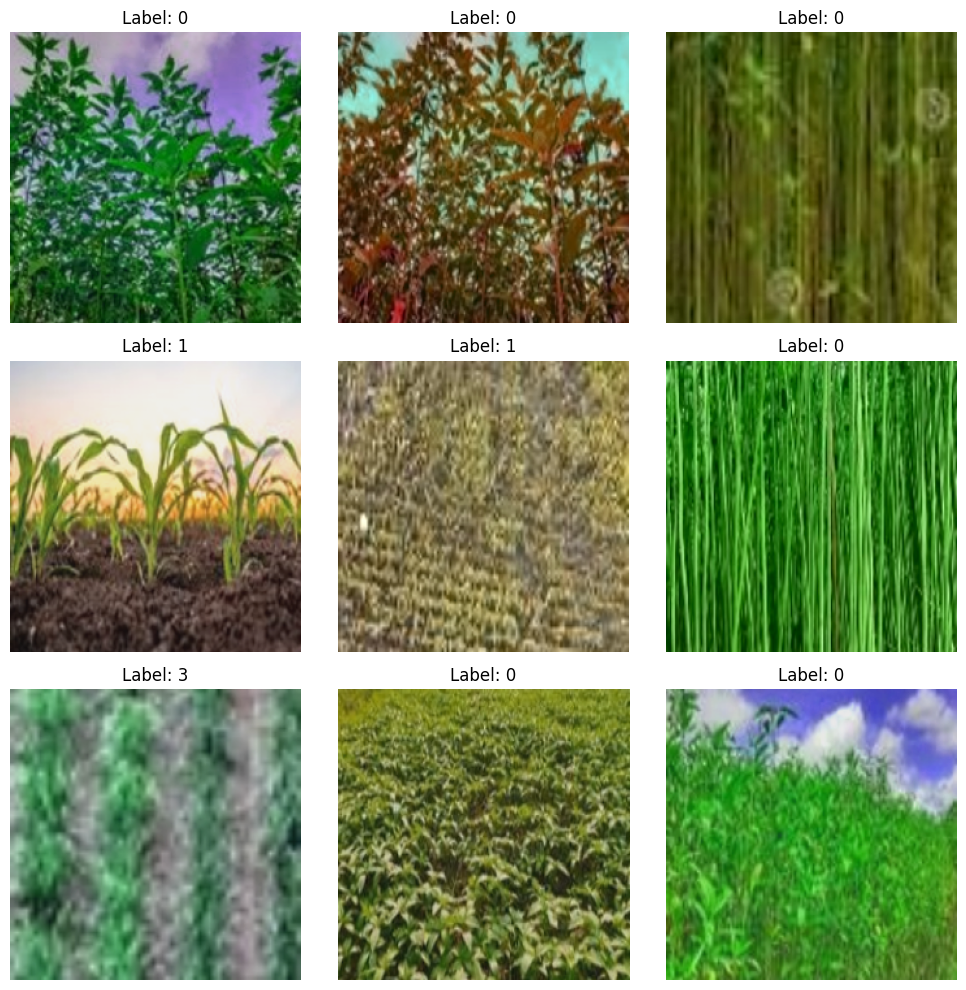

In [7]:
import numpy as np
# %pip install matplotlib
import matplotlib.pyplot as plt
num_images = 9

grid_dim = int(np.sqrt(num_images))

fig, axes = plt.subplots(grid_dim, grid_dim, figsize=(10, 10))


axes = axes.flatten()

for i in range(num_images):
    img = images[i]  
    label = labels[i]  

   
   
    img = np.transpose(img.numpy(), (1, 2, 0)) # C, H, W -> H, W, C 

    axes[i].imshow(img)  
    axes[i].set_title(f'Label: {label}')  # Set title 
    axes[i].axis('off')  

# Adjust layout
plt.tight_layout()
plt.show()

In [8]:
import torch.nn as nn
import torchvision.models as models

# Load pretrained VGG16 model
pre_model = models.vgg16(pretrained=True)


for param in pre_model.parameters():
    param.requires_grad = False


for param in pre_model.features[-6:].parameters():
    param.requires_grad = True
    


c:\Users\Nikhil\OneDrive\Desktop\DL\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Nikhil\OneDrive\Desktop\DL\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256, 5)  
)
pre_model.classifier = classifier
# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = pre_model.to(device)
print(f"Running on {device}")

Running on cuda


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [11]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/10], Loss: 1.0110
Epoch [2/10], Loss: 0.6139
Epoch [3/10], Loss: 0.4085
Epoch [4/10], Loss: 0.3743
Epoch [5/10], Loss: 0.3145
Epoch [6/10], Loss: 0.2434
Epoch [7/10], Loss: 0.2831
Epoch [8/10], Loss: 0.2161
Epoch [9/10], Loss: 0.2182
Epoch [10/10], Loss: 0.2153


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

In [28]:
test_correct_predictions = 0
test_total_samples = 0

model.eval()
with torch.no_grad():
    for image, labels in val_loader:
        image, labels = image.to(device), labels.to(device)

        outputs = model(image)
        loss = criterion(outputs, labels)   

        _, predicted = torch.max(outputs, 1)
        test_correct_predictions += (predicted == labels).sum().item()
        test_total_samples += labels.size(0)

test_accuracy = test_correct_predictions / test_total_samples
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


Test Accuracy: 92.16%


In [29]:
# Save the model
# torch.save(pre_model.state_dict(), 'vgg16_crops_model.pth')

In [30]:
# # initialize a model with the same architecture as the model which parameters you saved into the .pt/h file
# import torch
# import torch.nn as nn
# import torchvision.models as models
# classifier = nn.Sequential(
#     nn.Linear(512 * 7 * 7, 512),
#     nn.ReLU(),
#     nn.BatchNorm1d(512),
#     nn.Linear(512, 256),
#     nn.ReLU(),
#     nn.BatchNorm1d(256),
#     nn.Linear(256, 5)  
# )
# model= models.vgg16(pretrained=False)
# model.classifier = classifier
# # load the parameters into the model
# model.load_state_dict(torch.load("./vgg16_crops_model.pth"))

In [31]:
# from PIL import Image
# from torchvision import transforms
# img=Image.open("./m.jpeg")
# transform=transforms.Compose([
#     transforms.Resize(224,224),
#     transforms.ToTensor()
# ])
# image=transform(img)
# image=image.unsqueeze(0)
# output=model(image)
# o,p=torch.max(output,1)